In [1]:
__author__ = 'Robert Nikutta <robert.nikutta@noirlab.edu> and the Astro Data Lab team <datalab@noirlab.edu>'
__version__ = '20230728' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['allwise', 'smash']
__keywords__ = ['authentication', 'histogram', 'plot:cmd', 'RRLyrae', 'lightcurve']

# Data Lab data access examples
_Robert Nikutta and the Astro Data Lab Team_

### Table of contents
* [Module imports](#import)
* [Authentication](#auth)
* [Magnitude distribution in WISE](#histogram)
* [Color-magnitude diagram of a dwarf galaxy](#cmd)
* [Light curve of RRLyrae star](#lightcurve)

# Goals
To demonstrate how to:
* Import Data Lab (and other) packages
* Log in to Data Lab (if required)
* Issue simple SQL queries against database tables in Data Lab
* Make 1d (histogram) and 2d (color-magnitude diagram) plots of the retrieved data
* Query for the light curve of a variable star and plot it

# Summary
This notebook shows very short examples of how different data can be queried in Data Lab, and what you can do with them.

Also experiment with the notebooks in [Getting Started With Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/01_GettingStartedWithDataLab/02_GettingStartedWithDataLab.ipynb)

# Disclaimer & attribution
If you use parts of this or other notebooks for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup
Let's import a few Python packages, and the relevant Data Lab modules. 

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import pylab as plt
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc #, storeClient as sc
from dl.helpers.utils import convert

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

<a class="anchor" id="histogram"></a>
# Magnitude distribution
In this example we query the AllWISE database (the `source` table) for the measured magnitudes in 3 bands of 10k sources with high SNR.

In [4]:
query =\
"""
select w1mpro,w2mpro,w3mpro
from allwise.source
where w1snr>30 and w2snr>30 and w3snr>30
limit 10000
"""
res = qc.query(sql=query,format='csv')

Let's convert the result of the query to a convenient format (here a Pandas dataframe).

In [5]:
df = convert(res,'pandas')

We'll plot the distributions of the WISE W1, W2, W3 magnitudes as histograms.

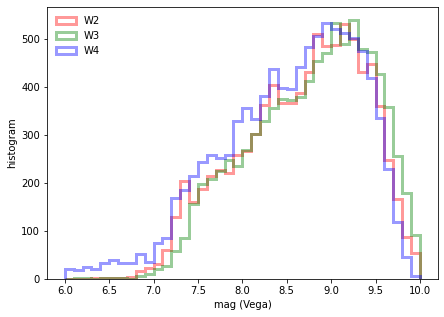

In [6]:
colors = list('rgb')
fig, ax = plt.subplots(1,1,figsize=(7,5))
for j in (1,2,3):
    ax.hist(df['w{:d}mpro'.format(j)],bins=40,range=(6,10),histtype='step',lw=3,color=colors[j-1],alpha=0.4,label='W{:d}'.format(j+1))
ax.set_xlabel('mag (Vega)')
ax.set_ylabel('histogram')
ax.legend(loc='upper left',frameon=False)

<a class="anchor" id="cmd"></a>
# Color magnitude diagram
In this example we query for the photometry of stars around the known location of the Hydra II dwarf Galaxy, and generate a color-magnitude diagram (CDM) of them.

Let's define the query string. We ask for point-like objects `(abs(sharp<0.5))` in field number `169`, deteceted in long exposure images (`depthflag>1`), with `g` magnitudes between `9` and `25`, around a central position `ra0/dec0`, withing `0.1` degrees radius.

In [7]:
field, ra0, dec0, radius = 169, 185.410559533, -31.9760034474, 0.1 # ra0,dec0,radius all in decimal degrees
query = """
SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
  WHERE fieldid = {:d}
    AND depthflag > 1
    AND abs(sharp) < 0.5
    AND gmag BETWEEN 9 AND 25
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
""".format(field,ra0,dec0,radius)

Submit the query and convert to Pandas:

In [8]:
response = qc.query(sql=query,format='csv')
df = convert(response,'pandas')
print(df.head())

           ra        dec       gmag       rmag       imag
0  185.347863 -32.058646  22.300820  21.167992  20.728119
1  185.345062 -32.054665  23.378016  21.751303  21.199726
2  185.354247 -32.055922  22.539667  24.535675  23.734186
3  185.353235 -32.054740  23.123001  22.568447  22.088177
4  185.321045 -32.040530  24.278828  24.717794  24.606342


Compute a color column (in the same dataframe):

In [9]:
df['g_r'] = df['gmag'] - df['rmag']
print(df.head())

           ra        dec       gmag       rmag       imag       g_r
0  185.347863 -32.058646  22.300820  21.167992  20.728119  1.132828
1  185.345062 -32.054665  23.378016  21.751303  21.199726  1.626713
2  185.354247 -32.055922  22.539667  24.535675  23.734186 -1.996008
3  185.353235 -32.054740  23.123001  22.568447  22.088177  0.554554
4  185.321045 -32.040530  24.278828  24.717794  24.606342 -0.438966


Plot a color-magnitude diagram:

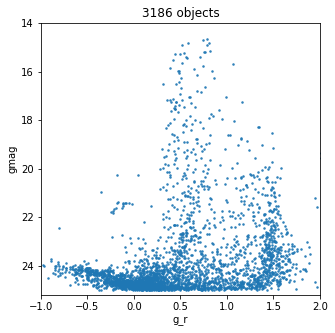

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
x = df['g_r']
y = df['gmag']
ax.scatter(x,y,marker='.',s=10, alpha=0.8)
ax.set_xlabel(x.name)
ax.set_ylabel(y.name)
ax.set_xlim((-1,2))
ax.set_ylim((25.2,14))
title = ax.set_title('{:d} objects'.format(len(df)))

<a class="anchor" id="lightcurve"></a>
# Light curve
Some catalogs have multi-epoch data, such as the SMASH survey. We will query for the magnitudes and their errors of all measurements of a star, whose ID we know.

In [11]:
# Unique ID of a RR Lyrae star in Hydra II dwarf galaxy
objID = '169.429960'

# Select columns: RA, Dec, modified Julian date, calibrated mag, uncertainties, filter band
# Note: this database table encodes 'no measurement' values as 99.99
# Order the returned rows by ascending mod. Julian date
query = """SELECT ra,dec,mjd,cmag,cerr,filter
        FROM smash_dr1.source
        WHERE id='{:s}' AND cmag<99
        ORDER BY mjd ASC""".format(objID)
result = qc.query(sql=query) # by default the result is a CSV formatted string

Convert to Pandas for convenience

In [12]:
df = convert(result,'pandas') # convert query result to a Pandas dataframe
print(df.head())

           ra        dec           mjd       cmag      cerr filter
0  185.431155 -31.995327  56371.327538  21.433147  0.020651      g
1  185.431146 -31.995324  56371.328563  21.231598  0.022473      r
2  185.431139 -31.995320  56371.329582  21.149094  0.026192      i
3  185.431142 -31.995334  56371.330610  21.237938  0.045429      z
4  185.431145 -31.995325  56371.331633  21.346725  0.015112      g


Let's plot the lightcurve as function of date

Text(0, 0.5, 'g magnitude')

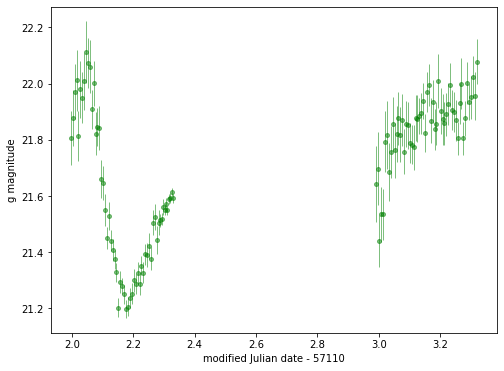

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
co = (df['filter']=='g')
start = 16
jd0 = 57110
ax.errorbar(df['mjd'][co][start:]-jd0,df['cmag'][co][start:],yerr=df['cerr'][co][start:],marker='.',ms=8,ls='none',color='g',lw=1,alpha=0.5,label='')
ax.set_xlabel('modified Julian date - {:d}'.format(jd0))
ax.set_ylabel('g magnitude')

A more complete example of time series analysis is shown in the [notebook on RRLyrae stars](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/TimeSeriesAnalysisRrLyraeStar/TimeSeriesAnalysisOfRrLyraeStar.ipynb).